In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from preprocessing.logParser import openLogs
from content.video import Video

ImportError: cannot import name 'Video'

In [5]:
cursor = openLogs('logs/spbu_ACADRU_spring_2018-TL')

In [224]:
# test

request = """
        select *
        from play_video
        where user_id = 124086
        and page = "{}"
        """.format("https://courses.openedu.ru/courses/course-v1:spbu+ACADRU+spring_2018/courseware/b434df438c2045eba63afc089d64b3de/244a81ebf8a64b609cd8587bbe18edc5/")
cursor.execute(request)
data = cursor.fetchall()

columns_names = []
for i in cursor.description[:]:
    columns_names.append(i[0])

df = pd.DataFrame(data=data, columns=columns_names)
df

,user_id,course_name,execute_time,page,video_time
0,124086,course-v1:spbu+ACADRU+spring_2018,2018-03-31T16:02:07.717922+00:00,https://courses.openedu.ru/courses/course-v1:s...,0.0


In [2]:
def check_video(page):
    video_events = ["hide_transcript", "pause_video",
                    "play_video", "seek_video",
                    "show_transcript", "speed_change_video", "stop_video",
                    "video_hide_cc_menu", "video_show_cc_menu"]

    for i in video_events:
        request = """
                    select *
                    from {}
                    where page = "{}"
                    """.format(i, page)
        cursor.execute(request)
        data = cursor.fetchall()
        if data : return True
    return False

# Video review

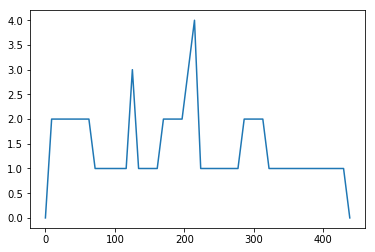

In [6]:
from content.video.video_review import get_video_review

videos = get_video_review(cursor)
video = videos[9]
plt.plot(np.linspace(0, video.length, video.intervals_number), video.review_intervals)
plt.show()

# What part of video was watched

In [7]:
from content.video_watched_percent import set_watched_percent

set_watched_percent(cursor, videos)

# Output

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

from preprocessing.logParser import openLogs

from content.video_review import get_video_review
from content.video_watched_percent import set_watched_percent
from content.video import Video

if __name__ == '__main__':

    cursor = openLogs('logs/spbu_ACADRU_spring_2018-TL')

    videos = get_video_review(cursor)
    set_watched_percent(cursor, videos)

In [6]:
videos[9].page

'https://courses.openedu.ru/courses/course-v1:spbu+ACADRU+spring_2018/courseware/7f4d3d8d4b1a4e4b853deb4325167221/19dab2595da548c5b533976144c5685e/'